# ML Zoomcamp 2023, Homework 4 (evaluation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
df = df[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.fillna(0, inplace=True)
mean_price = df['msrp'].mean()
df['above_average'] = df['msrp'].apply(lambda x: 1 if x > mean_price else 0) 
df.drop(['msrp'], axis=1, inplace=True)

In [3]:
SEED = 1
y = df.above_average.values
X = df.drop(['above_average'], axis=1)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.4, random_state = SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = SEED)

In [4]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['model','make','transmission_type','vehicle_style']
for f in numerical:
   
    if metrics.roc_auc_score(y_train, X_train[f]) > 0.5:
        print(f, metrics.roc_auc_score(y_train, X_train[f]))
    else: 
        print(f, metrics.roc_auc_score(y_train, -X_train[f]))
        

year 0.6943018002799936
engine_hp 0.9159001518508375
engine_cylinders 0.768274900593613
highway_mpg 0.6333685399678282
city_mpg 0.67232674562278


engine_hp has the highest AUC

In [5]:
train_dict = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train1 = dv.transform(train_dict)
val_dict = X_val.to_dict(orient='records')
X_val1 = dv.transform(val_dict) 

In [6]:
clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=SEED) 
clf.fit(X_train1,y_train)
y_pred = clf.predict(X_val1)
print(round(metrics.roc_auc_score(y_val,y_pred),3))

0.918


In [7]:
y_pred = clf.predict_proba(X_val1)[:, 1]
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    score = metrics.accuracy_score(y_val, y_pred >= t)
    scores.append(score)

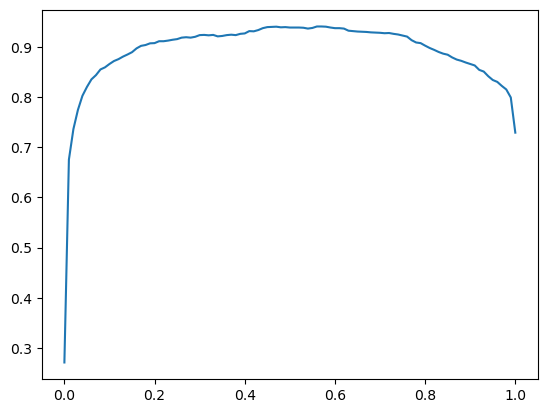

In [8]:
plt.plot(thresholds, scores)

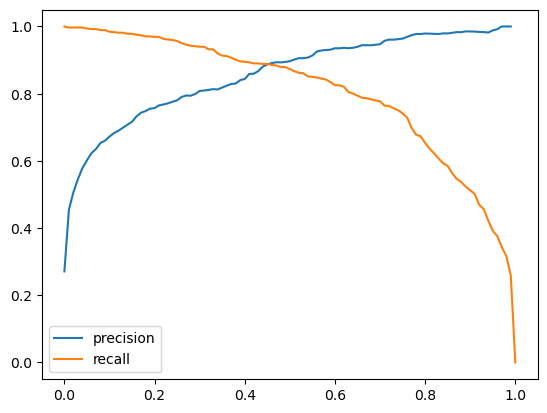

In [9]:
y_pred = clf.predict_proba(X_val1)[:, 1]

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

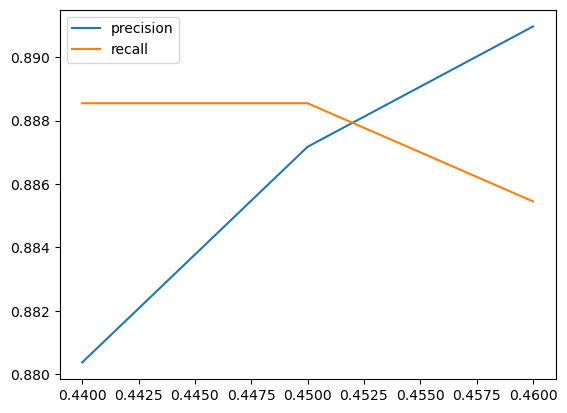

In [10]:
plt.plot([0.44,0.45,0.46], df_scores[(df_scores['threshold'] >= 0.44) & (df_scores['threshold'] <= 0.46)]['precision'], label='precision')
plt.plot([0.44,0.45,0.46], df_scores[(df_scores['threshold'] >= 0.44) & (df_scores['threshold'] <= 0.46)]['recall'], label='recall')
plt.legend()

0.48 is the closest threshold to the intersection among the listed options. 

In [11]:
df_scores['f1'] = 2*df_scores['recall']*df_scores['precision'] / (df_scores['recall']+df_scores['precision'])

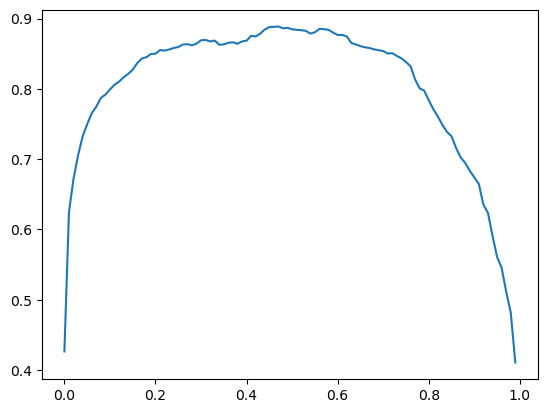

In [12]:
plt.plot(df_scores.threshold, df_scores['f1'], label='df')

In [13]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
47,0.47,571,68,75,1669,0.893584,0.883901,0.888716


0.52 is the closest answer among listed one. 

In [14]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [15]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [16]:
X_train, X_test_val, y_train, y_test_val = train_test_split(df, y, test_size = 0.4, random_state = SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = SEED)

In [17]:
n_splits = 5

for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    scores = []

    for train_idx, val_idx in kfold.split(X_train):
        df_train = X_train.iloc[train_idx]
        df_val = X_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = metrics.roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.949 +- 0.005
C=0.1 0.968 +- 0.004
C=0.5 0.977 +- 0.003
C=10 0.982 +- 0.003


Hence, for C=1 std = 0.004 (closest answer is 0.003) and C=10 gives the best mean score. 